# 04.6a5 Quasar Angular Census

**Question:** If we stand at `<|endoftext|>` and measure the causal angle to every other token, what's the distribution?

In high-dimensional space, random vectors are typically nearly orthogonal (cosine similarity ≈ 0). But our token space isn't random — it has structure.

## Method

1. Pick a reference token (quasar): `<|endoftext|>`
2. Compute **causal cosine similarity** to all other tokens:
   ```
   cos(θ) = (v^T M q) / (||v||_M ||q||_M)
   ```
3. Histogram the distribution
4. Bin tokens into three categories:
   - **Antiparallel** (cos < -0.1): Pointing opposite direction
   - **Orthogonal** (|cos| ≤ 0.1): Perpendicular-ish
   - **Parallel** (cos > +0.1): Pointing same direction

## Expected Results

**If OOPS ALL ORTHOGONAL**: `<|endoftext|>` is geometrically typical, just happens to be far away

**If biased toward parallel/antiparallel**: It encodes some semantic direction that other tokens align with or oppose

## Why Causal Only?

We measure angles using the causal metric M because that's the "true" geometry of semantic space. Euclidean angles are artifacts of the parameter space representation.

## Configuration

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from transformers import AutoModelForCausalLM, AutoTokenizer

# Model and paths
MODEL_NAME = "Qwen/Qwen3-4B-Instruct-2507"
METRIC_PATH = Path("../data/vectors/causal_metric_tensor_qwen3_4b.pt")

# Reference token (from 04.6a results)
QUASAR_TOKEN_ID = 151643  # <|endoftext|>

# Binning thresholds
ORTHO_THRESHOLD = 0.1  # |cos(θ)| ≤ this → "orthogonal"

# Device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


## Load Model, Tokenizer, and Metric Tensor

In [2]:
# Load metric tensor
print("Loading causal metric tensor...")
metric_data = torch.load(METRIC_PATH, map_location=device, weights_only=True)
M = metric_data['M']
print(f"M shape: {M.shape}")
print()

# Load model for gamma matrix
print(f"Loading {MODEL_NAME}...")
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16,
    device_map=device,
)
model.eval()

# Extract gamma (unembedding matrix)
gamma = model.lm_head.weight.data.to(dtype=torch.float32, device=device)
vocab_size, hidden_dim = gamma.shape
print(f"Gamma shape: {gamma.shape}")
print(f"Vocabulary size: {vocab_size:,} tokens")
print()

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print("Tokenizer loaded.")

# Verify quasar token
quasar_str = tokenizer.decode([QUASAR_TOKEN_ID])
print(f"\nQuasar token: ID {QUASAR_TOKEN_ID} → {repr(quasar_str)}")

Loading causal metric tensor...
M shape: torch.Size([2560, 2560])

Loading Qwen/Qwen3-4B-Instruct-2507...


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Gamma shape: torch.Size([151936, 2560])
Vocabulary size: 151,936 tokens

Tokenizer loaded.

Quasar token: ID 151643 → '<|endoftext|>'


## Compute Causal Norms for All Tokens

In [3]:
print("Computing causal norms for all tokens...")
gamma_M = gamma @ M  # [vocab_size, hidden_dim]
causal_norms_squared = (gamma_M * gamma).sum(dim=1)  # [vocab_size]
causal_norms = torch.sqrt(torch.clamp(causal_norms_squared, min=0))  # [vocab_size]

print(f"Mean causal norm: {causal_norms.mean().item():.4f} logometers")
print(f"Quasar causal norm: {causal_norms[QUASAR_TOKEN_ID].item():.4f} logometers")
print()

Computing causal norms for all tokens...
Mean causal norm: 54.1318 logometers
Quasar causal norm: 85.2873 logometers



## Compute Causal Cosine Similarities

For all tokens v, compute:
```
cos(θ) = (v^T M q) / (||v||_M ||q||_M)
```

where q is the quasar token.

In [4]:
print(f"Computing causal cosine similarities to {repr(quasar_str)}...")

# Extract quasar vector
quasar_vec = gamma[QUASAR_TOKEN_ID]  # [hidden_dim]
quasar_norm = causal_norms[QUASAR_TOKEN_ID]

# Causal inner products: v^T M q for all v
# gamma_M already computed above: gamma @ M
causal_dots = (gamma_M * quasar_vec).sum(dim=1)  # [vocab_size]

# Causal cosine: (v^T M q) / (||v||_M ||q||_M)
causal_cosines = causal_dots / (causal_norms * quasar_norm)  # [vocab_size]

# Clamp to [-1, 1] for numerical stability
causal_cosines = torch.clamp(causal_cosines, -1.0, 1.0)

print(f"Computed {len(causal_cosines):,} cosine similarities.")
print()

# Convert to numpy for analysis
cosines_np = causal_cosines.cpu().numpy()

# Basic statistics
print("Distribution statistics:")
print(f"  Mean:   {cosines_np.mean():.6f}")
print(f"  Median: {np.median(cosines_np):.6f}")
print(f"  Std:    {cosines_np.std():.6f}")
print(f"  Min:    {cosines_np.min():.6f}")
print(f"  Max:    {cosines_np.max():.6f}")
print()

Computing causal cosine similarities to '<|endoftext|>'...
Computed 151,936 cosine similarities.

Distribution statistics:
  Mean:   -0.000002
  Median: -0.000362
  Std:    0.018205
  Min:    -0.123539
  Max:    1.000000



## Bin Tokens by Angular Relationship

In [5]:
# Bin tokens
antiparallel = cosines_np < -ORTHO_THRESHOLD
orthogonal = np.abs(cosines_np) <= ORTHO_THRESHOLD
parallel = cosines_np > ORTHO_THRESHOLD

n_antiparallel = antiparallel.sum()
n_orthogonal = orthogonal.sum()
n_parallel = parallel.sum()

print("="*70)
print(f"ANGULAR CENSUS: Tokens relative to {repr(quasar_str)}")
print("="*70)
print()
print(f"Threshold for orthogonality: |cos(θ)| ≤ {ORTHO_THRESHOLD}")
print()
print(f"{'Category':<20s} {'Count':>10s} {'Percentage':>12s}")
print("-"*70)
print(f"{'Antiparallel (←)':<20s} {n_antiparallel:>10,d} {n_antiparallel/vocab_size:>11.1%}")
print(f"{'Orthogonal (⊥)':<20s} {n_orthogonal:>10,d} {n_orthogonal/vocab_size:>11.1%}")
print(f"{'Parallel (→)':<20s} {n_parallel:>10,d} {n_parallel/vocab_size:>11.1%}")
print("-"*70)
print(f"{'TOTAL':<20s} {vocab_size:>10,d} {1.0:>11.1%}")
print()

# Interpretation
if n_orthogonal / vocab_size > 0.95:
    print("✓ OOPS ALL ORTHOGONAL: Quasar is geometrically typical (random-ish direction)")
elif n_parallel > n_antiparallel * 2:
    print("✓ PARALLEL BIAS: Quasar aligns with some semantic direction")
elif n_antiparallel > n_parallel * 2:
    print("✓ ANTIPARALLEL BIAS: Quasar represents 'opposite' or 'negation' direction")
else:
    print("✓ MIXED: Some structure, but not overwhelmingly orthogonal")

ANGULAR CENSUS: Tokens relative to '<|endoftext|>'

Threshold for orthogonality: |cos(θ)| ≤ 0.1

Category                  Count   Percentage
----------------------------------------------------------------------
Antiparallel (←)             13        0.0%
Orthogonal (⊥)          151,843       99.9%
Parallel (→)                 80        0.1%
----------------------------------------------------------------------
TOTAL                   151,936      100.0%

✓ OOPS ALL ORTHOGONAL: Quasar is geometrically typical (random-ish direction)


## Visualize Distribution

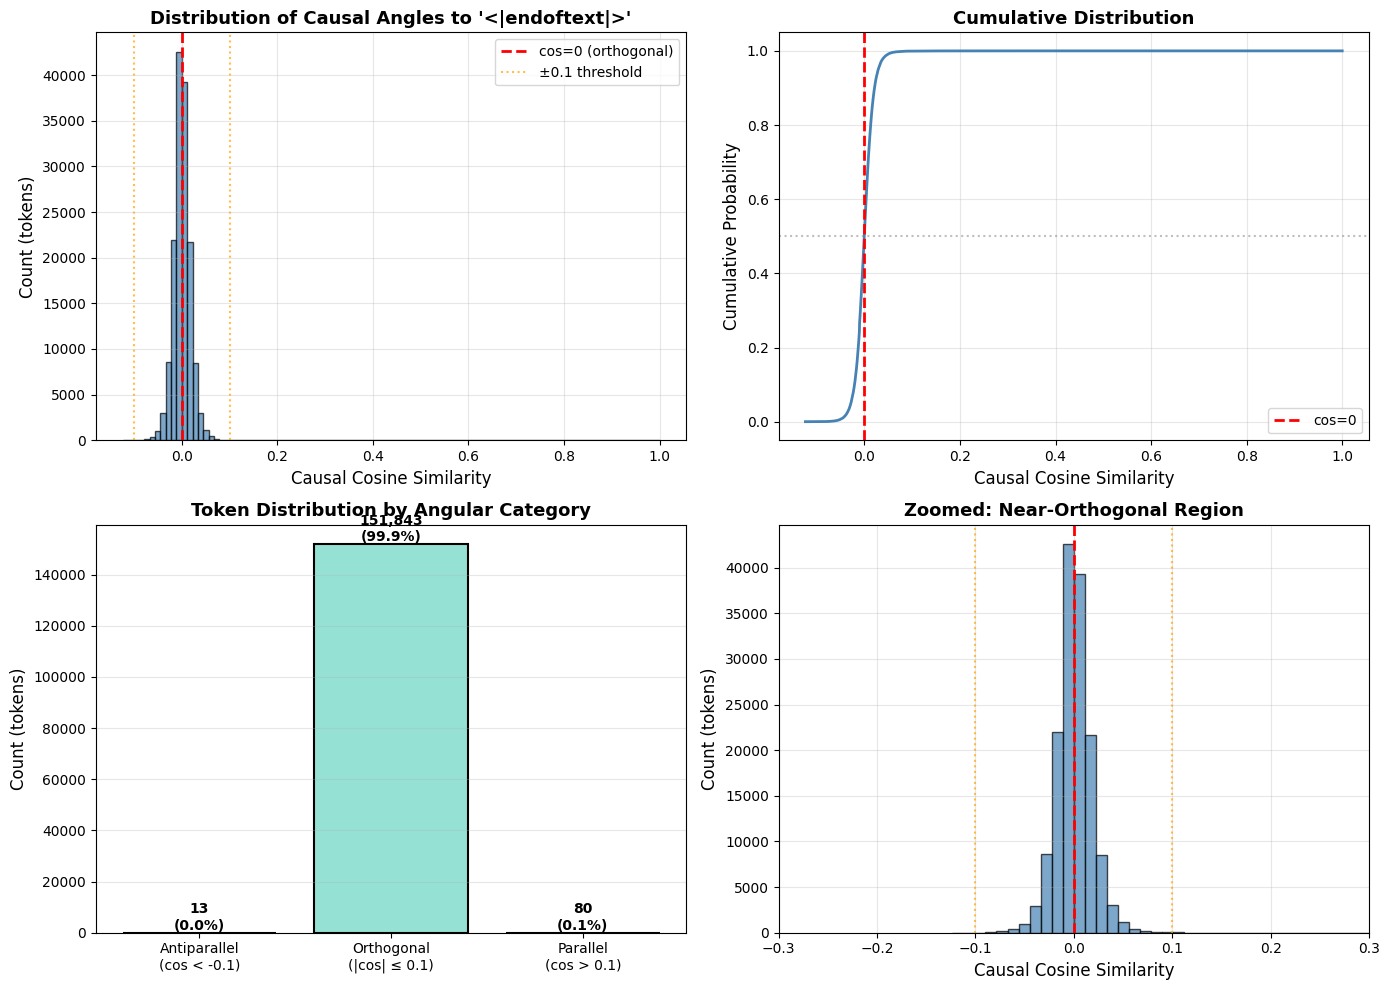

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Histogram of cosine similarities
ax = axes[0, 0]
ax.hist(cosines_np, bins=100, alpha=0.7, edgecolor='black', color='steelblue')
ax.axvline(0, color='red', linestyle='--', linewidth=2, label='cos=0 (orthogonal)')
ax.axvline(-ORTHO_THRESHOLD, color='orange', linestyle=':', linewidth=1.5, alpha=0.7)
ax.axvline(+ORTHO_THRESHOLD, color='orange', linestyle=':', linewidth=1.5, alpha=0.7, label=f'±{ORTHO_THRESHOLD} threshold')
ax.set_xlabel('Causal Cosine Similarity', fontsize=12)
ax.set_ylabel('Count (tokens)', fontsize=12)
ax.set_title(f'Distribution of Causal Angles to {repr(quasar_str)}', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# 2. Cumulative distribution
ax = axes[0, 1]
sorted_cosines = np.sort(cosines_np)
cumulative = np.arange(1, len(sorted_cosines) + 1) / len(sorted_cosines)
ax.plot(sorted_cosines, cumulative, linewidth=2, color='steelblue')
ax.axvline(0, color='red', linestyle='--', linewidth=2, label='cos=0')
ax.axhline(0.5, color='gray', linestyle=':', alpha=0.5)
ax.set_xlabel('Causal Cosine Similarity', fontsize=12)
ax.set_ylabel('Cumulative Probability', fontsize=12)
ax.set_title('Cumulative Distribution', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)

# 3. Bar chart of bins
ax = axes[1, 0]
categories = ['Antiparallel\n(cos < -0.1)', 'Orthogonal\n(|cos| ≤ 0.1)', 'Parallel\n(cos > 0.1)']
counts = [n_antiparallel, n_orthogonal, n_parallel]
colors = ['#ff6b6b', '#95e1d3', '#6bcf7f']
bars = ax.bar(categories, counts, color=colors, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Count (tokens)', fontsize=12)
ax.set_title('Token Distribution by Angular Category', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Add percentages on bars
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{count:,}\n({count/vocab_size:.1%})',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. Zoomed histogram around 0
ax = axes[1, 1]
ax.hist(cosines_np, bins=100, alpha=0.7, edgecolor='black', color='steelblue')
ax.axvline(0, color='red', linestyle='--', linewidth=2, label='cos=0 (orthogonal)')
ax.axvline(-ORTHO_THRESHOLD, color='orange', linestyle=':', linewidth=1.5, alpha=0.7)
ax.axvline(+ORTHO_THRESHOLD, color='orange', linestyle=':', linewidth=1.5, alpha=0.7)
ax.set_xlim(-0.3, 0.3)  # Zoom to [-0.3, +0.3]
ax.set_xlabel('Causal Cosine Similarity', fontsize=12)
ax.set_ylabel('Count (tokens)', fontsize=12)
ax.set_title('Zoomed: Near-Orthogonal Region', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Examine Extreme Cases

What tokens are most parallel and most antiparallel to the quasar?

In [7]:
# Most parallel (highest cosine)
top_parallel_indices = np.argsort(cosines_np)[-10:][::-1]  # Top 10, descending

print("="*80)
print(f"TOP 10 MOST PARALLEL to {repr(quasar_str)}")
print("="*80)
print()
for i, idx in enumerate(top_parallel_indices, 1):
    token_id = idx
    cos_val = cosines_np[idx]
    token_str = tokenizer.decode([token_id])
    token_repr = repr(token_str)
    print(f"{i:2d}. ID {token_id:6d} | cos={cos_val:+.6f} | {token_repr}")

print()
print("="*80)

# Most antiparallel (lowest cosine)
top_antiparallel_indices = np.argsort(cosines_np)[:10]  # Bottom 10

print(f"TOP 10 MOST ANTIPARALLEL to {repr(quasar_str)}")
print("="*80)
print()
for i, idx in enumerate(top_antiparallel_indices, 1):
    token_id = idx
    cos_val = cosines_np[idx]
    token_str = tokenizer.decode([token_id])
    token_repr = repr(token_str)
    print(f"{i:2d}. ID {token_id:6d} | cos={cos_val:+.6f} | {token_repr}")

print()
print("="*80)

# Most orthogonal (closest to 0)
ortho_deviations = np.abs(cosines_np)
top_orthogonal_indices = np.argsort(ortho_deviations)[:10]  # Closest to 0

print(f"TOP 10 MOST ORTHOGONAL to {repr(quasar_str)}")
print("="*80)
print()
for i, idx in enumerate(top_orthogonal_indices, 1):
    token_id = idx
    cos_val = cosines_np[idx]
    token_str = tokenizer.decode([token_id])
    token_repr = repr(token_str)
    print(f"{i:2d}. ID {token_id:6d} | cos={cos_val:+.6f} | {token_repr}")

TOP 10 MOST PARALLEL to '<|endoftext|>'

 1. ID 151643 | cos=+1.000000 | '<|endoftext|>'
 2. ID 151660 | cos=+0.333960 | '<|fim_middle|>'
 3. ID 148992 | cos=+0.271093 | 'ቤ'
 4. ID 109073 | cos=+0.232892 | '返回搜狐'
 5. ID 145645 | cos=+0.214163 | '▌'
 6. ID 111339 | cos=+0.197005 | '公网安'
 7. ID  79083 | cos=+0.194347 | '\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n'
 8. ID 120668 | cos=+0.193985 | '唿'
 9. ID  24616 | cos=+0.190624 | '\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n'
10. ID  45128 | cos=+0.180754 | '\n\n\n\n\n\n\n\n\n\n\n\n'

TOP 10 MOST ANTIPARALLEL to '<|endoftext|>'

 1. ID  66444 | cos=-0.123539 | ')*/\n'
 2. ID  43196 | cos=-0.118577 | '>--}}\n'
 3. ID 141277 | cos=-0.111769 | ' napisał'
 4. ID  96121 | cos=-0.110444 | '">-->\n'
 5. ID  42398 | cos=-0.107679 | '":"",\n'
 6. ID  53505 | cos=-0.106000 | '"""\n\n\n'
 7. ID  37626 | cos=-0.105915 | ' misunder'
 8. ID  58177 | cos=-0.105042 | ' ){\n\n'
 9. ID 145937 | cos=-0.104093 | '❈'
10. ID   9480 | cos=-0.103594 |

## Comparison to Random Expectation

In 2560-dimensional space, what's the expected distribution of cosine similarities for random vectors?

In [8]:
# For high-dimensional random vectors, cosine similarity is approximately
# normally distributed with mean 0 and std ≈ 1/sqrt(d)

d = hidden_dim
random_std = 1.0 / np.sqrt(d)

print("Random expectation (theoretical):")
print(f"  Dimensionality: {d}")
print(f"  Expected mean: 0.0")
print(f"  Expected std:  {random_std:.6f}")
print()

print("Observed (actual token space):")
print(f"  Observed mean: {cosines_np.mean():.6f}")
print(f"  Observed std:  {cosines_np.std():.6f}")
print()

# Compare
mean_diff = cosines_np.mean() - 0.0
std_ratio = cosines_np.std() / random_std

print("Comparison:")
print(f"  Mean deviation from 0: {mean_diff:+.6f}")
print(f"  Std ratio (observed/expected): {std_ratio:.4f}")
print()

if abs(mean_diff) > 0.01:
    if mean_diff > 0:
        print("✓ Tokens are BIASED TOWARD quasar (mean > 0)")
    else:
        print("✓ Tokens are BIASED AWAY from quasar (mean < 0)")
else:
    print("✓ Mean is close to 0 (no strong directional bias)")

if std_ratio > 1.5:
    print("✓ Spread is WIDER than random (more structure)")
elif std_ratio < 0.67:
    print("✓ Spread is NARROWER than random (clustered near orthogonal)")
else:
    print("✓ Spread is similar to random expectation")

Random expectation (theoretical):
  Dimensionality: 2560
  Expected mean: 0.0
  Expected std:  0.019764

Observed (actual token space):
  Observed mean: -0.000002
  Observed std:  0.018205

Comparison:
  Mean deviation from 0: -0.000002
  Std ratio (observed/expected): 0.9211

✓ Mean is close to 0 (no strong directional bias)
✓ Spread is similar to random expectation


## Summary

This notebook measured the distribution of causal angles between a reference quasar (`<|endoftext|>`) and all other tokens.

**Key questions answered**:
- Is the quasar geometrically typical (OOPS ALL ORTHOGONAL)?
- Or does it encode some semantic direction (parallel/antiparallel bias)?
- How does the distribution compare to random high-dimensional vectors?

**Interpretation guides**:
- **>95% orthogonal** → Quasar is a random direction, just happens to be far away
- **Parallel bias** → Quasar aligns with semantic content
- **Antiparallel bias** → Quasar represents "opposite" or "negation"
- **Wider spread than random** → Angular structure (not just distance)

**Next**: Repeat for other quasars (`\n`, `\u200b\u200b`) to see if pattern holds.